In [1]:
DATA_DIR = "./data"
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
!pip install ipympl scipy numpy Pillow matplotlib &> /dev/null
%matplotlib widget 

In [2]:
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/train.tar \
    && mv $DATA_DIR/train $DATA_DIR/streethazards_train
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/test.tar\
    && mv $DATA_DIR/test $DATA_DIR/streethazards_test

--2025-10-21 19:31:00--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘./data/train.tar’

./data/train.tar    100%[===================>]   8.74G  18.3MB/s    in 9m 35s  

2025-10-21 19:40:36 (15.6 MB/s) - ‘./data/train.tar’ saved [9386226176/9386226176]

--2025-10-21 19:40:55--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘./data/test.tar’

./data/test.tar     100%[==================

In [3]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
import numpy as np
import os
from enum import IntEnum
import torch
from torch import Tensor
import torch.nn as nn
import segmentation_models_pytorch as smp
from typing import Optional, Callable, Union, Tuple, Dict, List
import json
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label
import ipywidgets as widgets
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
known_classes = 13

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

cuda


In [5]:
class KaggleInteractiveLabeler:
    def __init__(self, image_array, anomaly_map, threshold, on_done_callback):
        self.image = image_array
        self.anomaly_map = anomaly_map
        self.threshold = threshold
        # La funzione da chiamare quando l'utente ha finito
        self.on_done_callback = on_done_callback 
        
        self.annotations = {}
        self.current_class_name = None
        self.is_labeling_active = False
        
        self.ood_mask = self.anomaly_map >= self.threshold
        self.labeled_regions, _ = label(self.ood_mask)
        
        self.setup_ui()
        
        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        self.update_display()
        print("Interfaccia pronta. Inserisci un nome e clicca 'Inizia a Etichettare'.")

    def setup_ui(self):
        """Crea i widget dell'interfaccia utente, incluso il bottone 'Fine'."""
        self.fig, self.ax = plt.subplots(figsize=(10, 7))
        self.text_input = widgets.Text(description='Classe:')
        self.button_start = widgets.Button(description="Inizia a Etichettare")
        self.button_done = widgets.Button(description="Fine e Procedi", button_style='success') # Nuovo bottone
        self.status_label = widgets.Label(value="Stato: In attesa.")

        self.button_start.on_click(self.on_start_button)
        self.button_done.on_click(self.on_done_button) # Collega il callback
        
        # Metti i bottoni in un HBox per allinearli orizzontalmente
        buttons_box = widgets.HBox([self.button_start, self.button_done])
        self.ui = widgets.VBox([
            widgets.HBox([self.text_input, buttons_box]),
            self.status_label,
            self.fig.canvas
        ])

    def on_done_button(self, b):
        """Callback per il bottone 'Fine e Procedi'."""
        self.status_label.value = "Processo terminato. Esecuzione della pipeline successiva..."
        # Nasconde l'interfaccia per evitare ulteriori modifiche
        self.ui.layout.display = 'none' 
        
        # Esegue la funzione passata al costruttore, dandole le annotazioni come input
        if self.on_done_callback:
            self.on_done_callback(self.annotations)

    # Il resto dei metodi della classe rimane invariato
    def update_display(self, message=None):
        self.ax.clear()
        self.ax.imshow(self.image)
        self.ax.imshow(self.anomaly_map, cmap='hot', alpha=0.5 * self.ood_mask)
        if self.annotations:
            combined_mask = np.zeros_like(self.labeled_regions, dtype=float)
            for i, mask in enumerate(self.annotations.values()):
                combined_mask[mask > 0] = i + 1
            self.ax.imshow(combined_mask, cmap='nipy_spectral', alpha=0.6)
        self.ax.set_title("Clicca sulle aree anomale per etichettarle")
        self.ax.axis('off')
        if message: self.status_label.value = message
        self.fig.canvas.draw_idle()

    def on_start_button(self, b):
        class_name = self.text_input.value.strip()
        if not class_name:
            self.update_display("Stato: Errore - Inserisci un nome valido per la classe.")
            return
        self.current_class_name = class_name
        self.is_labeling_active = True
        if self.current_class_name not in self.annotations:
            self.annotations[self.current_class_name] = np.zeros_like(self.image[:,:,0], dtype=np.uint8)
        self.update_display(f"Stato: Etichettatura attiva per '{self.current_class_name}'. Clicca su un oggetto.")

    def on_click(self, event):
        if not self.is_labeling_active or not event.inaxes or not event.xdata: return
        x, y = int(event.xdata), int(event.ydata)
        region_id = self.labeled_regions[y, x]
        if region_id == 0:
            self.update_display(f"Stato: Click fuori area anomala per '{self.current_class_name}'.")
            return
        mask_to_add = (self.labeled_regions == region_id)
        self.annotations[self.current_class_name][mask_to_add] = 1
        self.update_display(f"Stato: Aggiunta regione {region_id} alla classe '{self.current_class_name}'.")

In [6]:
"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
[  0,   0,   0], # // unlabeled     =   0, black
[ 70,  70,  70], # // building      =   1, gray
[190, 153, 153], # // fence         =   2, pinkish
[250, 170, 160], # // other         =   3, pink
[220,  20,  60], # // pedestrian    =   4, 
[153, 153, 153], # // pole          =   5,
[157, 234,  50], # // road line     =   6, 
[128,  64, 128], # // road          =   7,
[244,  35, 232], # // sidewalk      =   8,
[107, 142,  35], # // vegetation    =   9, 
[  0,   0, 142], # // car           =  10,
[102, 102, 156], # // wall          =  11, 
[220, 220,   0], # // traffic sign  =  12,
[ 60, 250, 240], # // anomaly       =  13,
]) 


def visualize_annotation(annotation_img: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a segmentation annotation using a predefined color palette.

    Args:
        annotation_img (np.ndarray | torch.Tensor): 2D array with class indices.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a raw RGB scene image.

    Args:
        image (np.ndarray | torch.Tensor): Image tensor or array in [C, H, W] or [H, W, C] format.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    
#path to streethazards dataset
train_odgt_file = f"{DATA_DIR}/streethazards_train/train.odgt"
val_odgt_file = f"{DATA_DIR}/streethazards_train/validation.odgt"
test_odgt_file = f"{DATA_DIR}/streethazards_test/test.odgt"

COMPUTE_MEAN_STD = False

In [7]:
class StreetHazardsDataset(Dataset):
    """
    A custom PyTorch Dataset for the StreetHazards inliner dataset.

    This dataset reads image and segmentation label paths from a `.odgt` file,
    applies optional resizing and spatial transformations, and returns
    dictionary-style samples with normalized image tensors and label tensors.

    Args:
        odgt_file (str): Path to the `.odgt` file containing image and label metadata.
        image_resize (Tuple[int, int], optional): Target size to resize images and labels. 
        spatial_transforms (Callable, optional): Optional transformation function applied to both images and labels.
        mean_std (Tuple[List[float], List[float]], optional): Mean and standard deviation for image normalization.
        
    """
    def __init__(
        self,
        odgt_file: str,
        image_resize: Tuple[int, int] = (512, 896),
        spatial_transforms: Optional[Callable] = None,
        mean_std: Tuple[List[float], List[float]] = None
    ):

        self.spatial_transforms = spatial_transforms
        self.mean_std = mean_std
        self.image_resize = image_resize

        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.spatial_transforms:
            image, labels  = self.spatial_transforms(image, labels)         

        #to_tensor
        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        
        labels = labels.squeeze(0)
        
        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)

        return {'image' : image, 'labels' : labels}

In [8]:
def create_one_hot_prototypes_torch(num_known_classes: int, t_value: float = 3.0, device: str = 'cpu') -> torch.Tensor:
    """
    Generates one-hot prototypes as a PyTorch tensor for a given number of known classes.
    Each prototype is a vector where only the element corresponding
    to its class index has the 't_value', and all other elements are 0.

    Args:
        num_known_classes (int): The total number of known (in-distribution) classes.
                                 This also determines the dimensionality of each prototype vector.
        t_value (float): The non-zero value at the class's specific index in the prototype.
                         As specified in the paper, this is often 3.0.
        device (str): The device on which to create the tensor ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A 2D PyTorch tensor where each row is a prototype vector.
                      The shape will be (num_known_classes, num_known_classes).
    """
    if not isinstance(num_known_classes, int) or num_known_classes <= 0:
        raise ValueError("num_known_classes must be a positive integer.")
    if not isinstance(t_value, (int, float)):
        raise ValueError("t_value must be a numeric type.")
    if device not in ['cpu', 'cuda']:
        raise ValueError("device must be 'cpu' or 'cuda'.")

    # Create a tensor of zeros
    prototypes = torch.zeros((num_known_classes, num_known_classes), dtype=torch.float32, device=device)

    # Fill the diagonal with t_value to create one-hot prototypes
    for i in range(num_known_classes):
        prototypes[i, i] = t_value
        
    # An even more concise way using torch.eye (Identity matrix)
    # prototypes = torch.eye(num_known_classes, dtype=torch.float32, device=device) * t_value

    return prototypes

Prototype  = create_one_hot_prototypes_torch(known_classes)

In [9]:
class DMLNetFeatureExtractor(torch.nn.Module):
    def __init__(self, encoder_name, encoder_weights, num_feature_channels, activation):
        super().__init__()
        

        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=num_feature_channels, # This sets the output channels of the segmentation_head if kept
            activation=activation # Usually 'None' for the main head, but for features it might not matter directly
        )

        for param in self.model.encoder.parameters():
            param.requires_grad = False
        

        # Option 2 is safer and more robust.
        # First, we disable the original segmentation head as you did.
        self.original_segmentation_head = self.model.segmentation_head # Store it if needed
        self.model.segmentation_head = torch.nn.Identity() # Remove the final head

        # --- CORRECTION START ---
        # To get the decoder's actual output channels, we need a dummy forward pass
        # through just the encoder and decoder.
        
        # Temporarily detach the module to make a dummy pass if needed,
        # but in __init__, we can usually just do a conceptual forward.
        # However, to be absolutely safe and get the runtime channel count:
        
        # Create a dummy input to trace the decoder output channels
        # Assuming typical RGB input (3 channels) and arbitrary spatial dimensions
        dummy_input = torch.randn(2, 3, 256, 256) 
        
        # Pass through encoder
        encoder_features_dummy = self.model.encoder(dummy_input)
        
        # Pass through decoder to get its output channels
        decoder_output_dummy = self.model.decoder(encoder_features_dummy)
        
        # Extract the channel dimension from the dummy output
        decoder_actual_out_channels = decoder_output_dummy.shape[1]
        # --- CORRECTION END ---

        # Add a 1x1 convolution to project the decoder's output to the desired num_feature_channels.
        self.feature_projection = torch.nn.Conv2d(
            in_channels=decoder_actual_out_channels,
            out_channels=num_feature_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        
    def forward(self, x):
        input_spatial_size = x.shape[2:]
        # The encoder outputs a list of feature maps at different resolutions
        encoder_features = self.model.encoder(x)
        
        # The decoder takes these features and produces a high-resolution feature map.
        # This output will typically have the same spatial dimensions as the input 'x'
        # (due to DeepLabV3+ decoder's upsampling) but with its default channel count.
        decoder_output = self.model.decoder(encoder_features)
        
        # Project the decoder's output to the desired number of feature channels
        projected_features = self.feature_projection(decoder_output)

        final_features = torch.nn.functional.interpolate(
            projected_features, 
            size=input_spatial_size, 
            mode='bilinear', 
            align_corners=False # Set to True for pixel alignment if needed, but False is common
        )
        
        # These `final_features` are your f(X; θf)i,j with num_feature_channels.
        return final_features

In [10]:
class DiscriminativeCrossEntropyLoss(nn.Module):
    def __init__(self, prototypes: torch.Tensor,lambda_weight):
        super().__init__()
       
        self.prototypes = prototypes.to(device)
        self.lambda_weight = lambda_weight

    def forward(self, pixel_features: torch.Tensor, target_labels: torch.Tensor):
        # pixel_features: (B, D, H, W)
        # target_labels: (B, H, W)

        # Reshape pixel_features for easier broadcasting with prototypes
        # (B, D, H, W) -> (B, H, W, D)
        pixel_features_reshaped = pixel_features.permute(0, 2, 3, 1) # (B, H, W, D)

        # Expand target_labels to match the feature dimension for indexing prototypes
        # (B, H, W) -> (B, H, W, D)
        prototypes_target = self.prototypes[target_labels] # This should now be (B, H, W, D)

        # --- Numerator (Attractive Force) ---
        # ||f(X; θf)i,j – mY i,j ||²
        # (B, H, W, D) - (B, H, W, D) -> (B, H, W, D)
        difference_numerator = pixel_features_reshaped - prototypes_target
        # (B, H, W, D) -> (B, H, W)
        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)

        # --- Denominator (Repulsive Force) ---
        # Σk=1 to N ( exp(-||f(X; θf)i,j – mk ||²) )
        # To compute this, we need to calculate the squared difference for ALL prototypes
        # and then sum their exponentials.

        # Expand pixel_features to compare with all prototypes: (B, H, W, 1, D)
        pixel_features_expanded = pixel_features_reshaped.unsqueeze(-2) # (B, H, W, 1, D)

        # Expand prototypes to compare with all pixels: (1, 1, 1, N, D)
        # self.prototypes has shape (N, D)
        prototypes_expanded = self.prototypes.unsqueeze(0).unsqueeze(0).unsqueeze(0) # (1, 1, 1, N, D)

        # Calculate difference between each pixel feature and ALL prototypes
        # (B, H, W, 1, D) - (1, 1, 1, N, D) -> (B, H, W, N, D)
        all_prototypes_differences = pixel_features_expanded - prototypes_expanded

        # Square and sum across the feature dimension (D)
        # (B, H, W, N, D) -> (B, H, W, N)
        squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)

        # Exponentiate
        # (B, H, W, N)
        exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)

        # Sum across the prototype dimension (N) to get the denominator
        # (B, H, W, N) -> (B, H, W)
        denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1)

        # --- Calculate Pt(Xi,j) (Equation 2) ---
        # (B, H, W) / (B, H, W) -> (B, H, W)
        pt_values = exp_squared_diff_numerator / (denominator + 1e-8) # Add small epsilon for stability

        # --- Calculate LDCE (Equation 3) ---
        # LDCE = -log(pt_values) for target classes
        # This requires masking based on target_labels or using the pt_values directly
        # The equation shows sum over i,j of -log(numerator/denominator) where numerator corresponds to Y_i,j

        # Assuming Y_i,j is 1 for the target class at that pixel and 0 otherwise.
        # This is essentially -log(Pt(Xi,j)) for the correct class, summed over all pixels.
        ldce_loss = -torch.log(pt_values + 1e-8) # Add small epsilon for stability
        ldce_loss = torch.sum(ldce_loss) # Or torch.sum() depending on how you want to aggregate

        Lvl_loss = torch.sum(difference_numerator.pow(2))
        
        # Check for NaNs/Infs
        if torch.isnan(pixel_features_reshaped).any():
            print("NaN found in pixel_features_reshaped!")
        if torch.isinf(pixel_features_reshaped).any():
            print("Inf found in pixel_features_reshaped!")
        
        
        return ldce_loss + self.lambda_weight * Lvl_loss
       

In [11]:
shape_resize = (512, 896)


spatial_transforms = transforms.v2.Compose([
    transforms.v2.RandomHorizontalFlip(),
])

train_dataset = StreetHazardsDataset(
    odgt_file= train_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=spatial_transforms,
)

val_dataset = StreetHazardsDataset(
    odgt_file= val_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
)

test_dataset = StreetHazardsDataset(
    odgt_file= test_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
)

train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Esempio di utilizzo:
encoder_name = "efficientnet-b0"
encoder_weights = "imagenet"
t_value = 3.0
epochs = 30

# Inizializza il feature extractor
feature_extractor = DMLNetFeatureExtractor(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    num_feature_channels=known_classes,
    activation=None
).to(device)
model_optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=0.02)

def train(num_epochs,model,train_loader,lambda_weight) -> None:
        
        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            
            model.train()

            losses = []

            for batch in train_loader: 

                    
                imgs = batch['image'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(imgs)
                
                lossClass = DiscriminativeCrossEntropyLoss(Prototype,lambda_weight)

                
                loss = lossClass(logits,labels)
                            
                losses.append(loss.item())
                
                model_optimizer.zero_grad()
                loss.backward()
                model_optimizer.step()
            
                del loss
                

            l = sum(losses) / len(losses)

            print(f"Epoch {epoch + 1} Loss {l}", end = ' ')

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [12]:
loaded_model = torch.load("/kaggle/input/dml/pytorch/default/11/model_weights10E_efficientnet-b0.pth",weights_only=False)
feature_extractor = loaded_model
print("model loaded")

model loaded


In [13]:
train(epochs,feature_extractor,train_dl,0.1)

Epoch:   3%|▎         | 1/30 [04:03<1:57:47, 243.72s/it]

Epoch 1 Loss 799858.4967823713 

Epoch:   7%|▋         | 2/30 [08:02<1:52:20, 240.72s/it]

Epoch 2 Loss 798404.5787831513 

Epoch:  10%|█         | 3/30 [11:59<1:47:36, 239.13s/it]

Epoch 3 Loss 798681.0135042901 

Epoch:  13%|█▎        | 4/30 [15:55<1:43:09, 238.06s/it]

Epoch 4 Loss 800802.837948518 

Epoch:  17%|█▋        | 5/30 [19:53<1:39:03, 237.73s/it]

Epoch 5 Loss 799812.8557917316 

Epoch:  20%|██        | 6/30 [23:51<1:35:08, 237.83s/it]

Epoch 6 Loss 799220.125048752 

Epoch:  23%|██▎       | 7/30 [27:47<1:30:58, 237.33s/it]

Epoch 7 Loss 797571.949200468 

Epoch:  27%|██▋       | 8/30 [31:43<1:26:54, 237.01s/it]

Epoch 8 Loss 797463.0815620124 

Epoch:  30%|███       | 9/30 [35:41<1:22:59, 237.12s/it]

Epoch 9 Loss 798281.1268525741 

Epoch:  33%|███▎      | 10/30 [39:37<1:18:58, 236.90s/it]

Epoch 10 Loss 799397.2072932917 

Epoch:  37%|███▋      | 11/30 [43:34<1:15:01, 236.91s/it]

Epoch 11 Loss 797671.1662441498 

Epoch:  40%|████      | 12/30 [47:30<1:10:57, 236.55s/it]

Epoch 12 Loss 800128.0112129485 

Epoch:  43%|████▎     | 13/30 [51:28<1:07:09, 237.01s/it]

Epoch 13 Loss 798598.0437792512 

Epoch:  47%|████▋     | 14/30 [55:25<1:03:12, 237.05s/it]

Epoch 14 Loss 798921.1720456318 

Epoch:  50%|█████     | 15/30 [59:21<59:10, 236.68s/it]  

Epoch 15 Loss 800866.5026326053 

Epoch:  53%|█████▎    | 16/30 [1:03:17<55:12, 236.60s/it]

Epoch 16 Loss 796535.9924921996 

Epoch:  57%|█████▋    | 17/30 [1:07:16<51:22, 237.15s/it]

Epoch 17 Loss 800052.6794071763 

Epoch:  60%|██████    | 18/30 [1:11:12<47:22, 236.86s/it]

Epoch 18 Loss 797437.8406786271 

Epoch:  63%|██████▎   | 19/30 [1:15:08<43:22, 236.58s/it]

Epoch 19 Loss 796872.2779836194 

Epoch:  67%|██████▋   | 20/30 [1:19:05<39:28, 236.82s/it]

Epoch 20 Loss 798801.8614469579 

Epoch:  70%|███████   | 21/30 [1:23:03<35:35, 237.27s/it]

Epoch 21 Loss 798667.9661661467 

Epoch:  73%|███████▎  | 22/30 [1:27:03<31:43, 237.98s/it]

Epoch 22 Loss 799258.9167804212 

Epoch:  77%|███████▋  | 23/30 [1:31:00<27:44, 237.77s/it]

Epoch 23 Loss 798253.2549239469 

Epoch:  80%|████████  | 24/30 [1:34:56<23:43, 237.19s/it]

Epoch 24 Loss 799446.5123829953 

Epoch:  83%|████████▎ | 25/30 [1:38:53<19:45, 237.09s/it]

Epoch 25 Loss 797726.0635725429 

Epoch:  87%|████████▋ | 26/30 [1:42:49<15:47, 236.89s/it]

Epoch 26 Loss 798595.6783346334 

Epoch:  90%|█████████ | 27/30 [1:46:45<11:49, 236.47s/it]

Epoch 27 Loss 799114.7147035882 

Epoch:  93%|█████████▎| 28/30 [1:50:43<07:53, 236.94s/it]

Epoch 28 Loss 798378.6680479719 

Epoch:  97%|█████████▋| 29/30 [1:54:40<03:56, 236.96s/it]

Epoch 29 Loss 799984.1547386895 

Epoch: 100%|██████████| 30/30 [1:58:37<00:00, 237.26s/it]

Epoch 30 Loss 799895.791975429 

In [14]:
torch.save(feature_extractor, "model_weights40E_efficientnet-b0.pth")

In [15]:
#loaded_model = torch.load("/kaggle/input/dml/pytorch/default/4/model.weights.pth",weights_only=False)
#loaded_model.eval()
#feature_extractor = loaded_model

In [16]:
def get_probability(logits, Prototype, device): # Passa Prototype e device come argomenti
    
    pixel_features_reshaped = logits.permute(0, 2, 3, 1) # (B, H, W, D)
    
    B, H, W, D = pixel_features_reshaped.shape
    N_CLASSES = Prototype.shape[0] 
    
    
    probability = torch.zeros(B, H, W, N_CLASSES, device=device)
    Prototypes_on_device = Prototype.to(device)
    pixel_features_expanded_for_denom = pixel_features_reshaped.unsqueeze(-2) 
    prototypes_expanded_for_denom = Prototypes_on_device.unsqueeze(0).unsqueeze(0).unsqueeze(0) 
    all_prototypes_differences = pixel_features_expanded_for_denom - prototypes_expanded_for_denom
    squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)
    exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)
    denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1, keepdim=True) + 1e-8 # keepdim per broadcasting

    for t in range(N_CLASSES):

        prototypes_t = Prototypes_on_device[t] 
        difference_numerator = pixel_features_reshaped - prototypes_t

        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)

        pt_values = exp_squared_diff_numerator / denominator.squeeze(-1) # Rimuovi la dimensione aggiunta per il broadcasting

        probability[:,:,:,t] = pt_values

    return probability

In [17]:
torch.cuda.memory._record_memory_history()

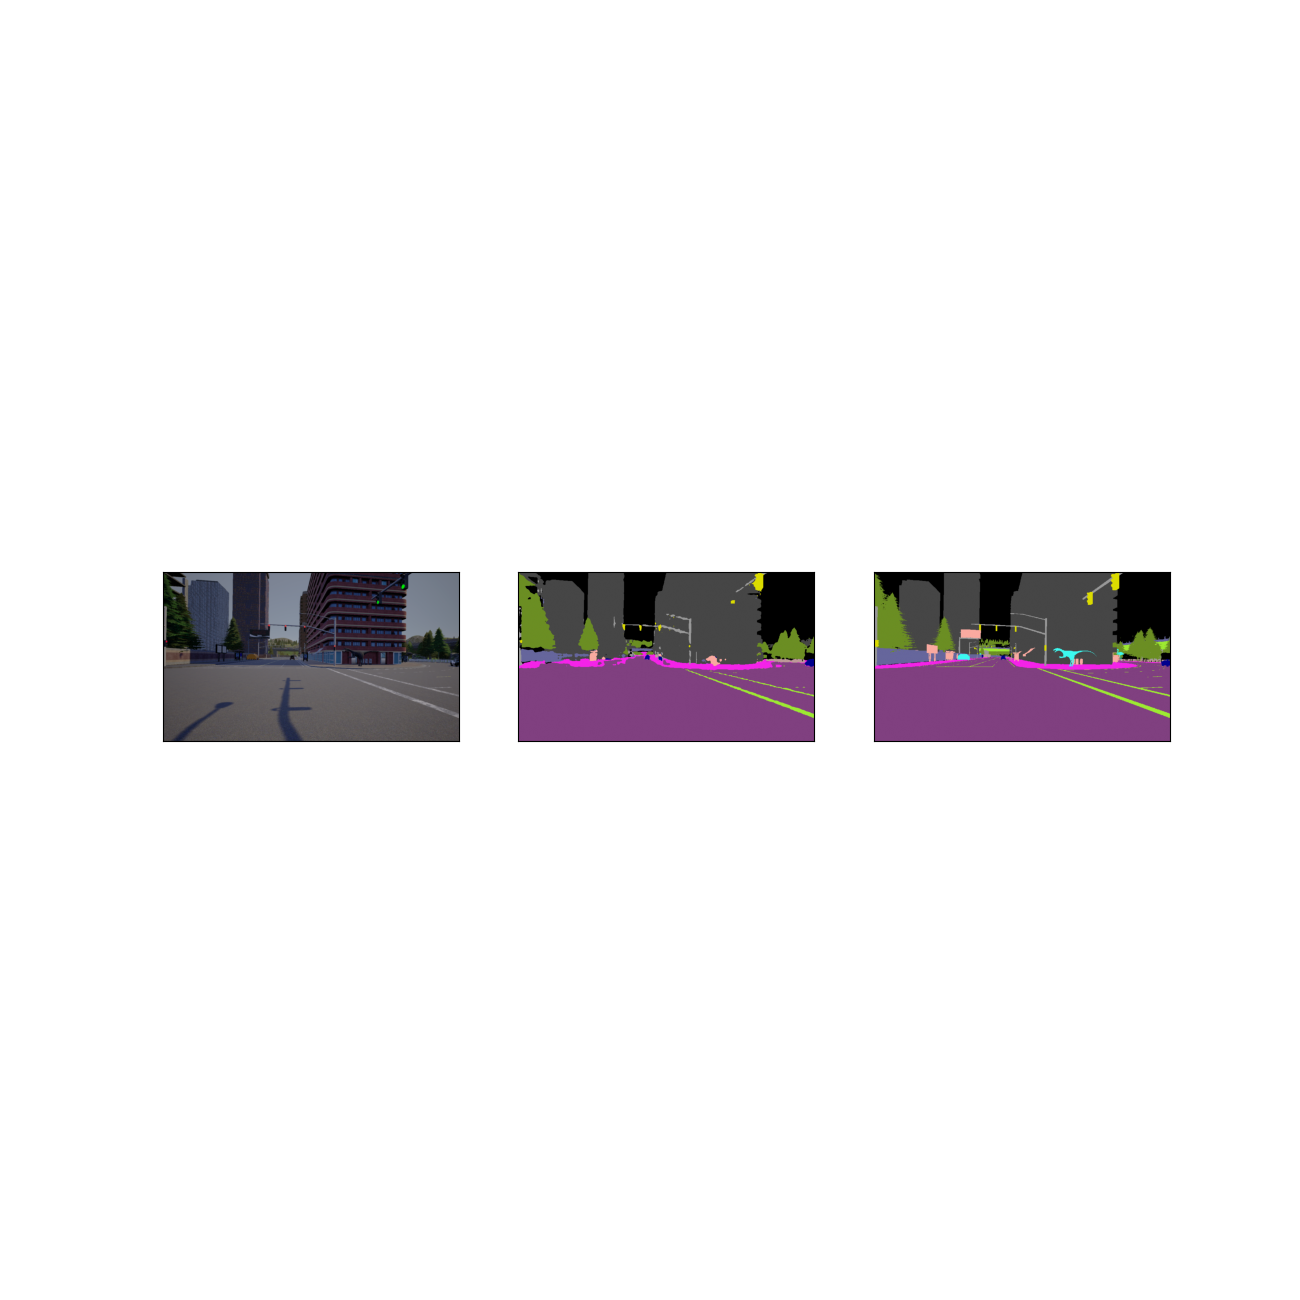

In [18]:
feature_extractor.eval()
with torch.no_grad():
    for batch in test_dl:
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
                    
        logits = feature_extractor(imgs)
        probability_vector = get_probability(logits,Prototype,device)
    
        fig, axs = plt.subplots(1, 3, figsize=(13, 13))
        idx = 3
        visualize_scene(imgs.cpu()[5], axs[0])
        visualize_annotation(torch.argmax(probability_vector,axis=3).cpu().detach().numpy()[5], axs[1])
        visualize_annotation(labels.cpu().detach().numpy()[5],axs[2])
        
        break
    
    

In [19]:
def MMSP(probability_map):
    MMSP_map = 1 - torch.max(probability_map, dim=3)[0] 
    return MMSP_map

In [20]:
def Probability_EDS(pixel_feature):
    pixel_features_reshaped = pixel_feature.permute(0, 2, 3, 1) 

    S_xy = torch.zeros(pixel_features_reshaped.shape[0], pixel_features_reshaped.shape[1], pixel_features_reshaped.shape[2], device=pixel_feature.device)
    
    for t in range(known_classes):
        prototypes_t = Prototype[t].to(device).view(1, 1, 1, -1)
        
        difference_numerator = pixel_features_reshaped - prototypes_t
        squared_diff_numerator = torch.sum(difference_numerator**2, dim=3)
        S_xy = S_xy + squared_diff_numerator

    MaxS = torch.max(S_xy) 
    P_EDS = 1 - S_xy / (MaxS + 1e-8) 
    
    return P_EDS

        
    

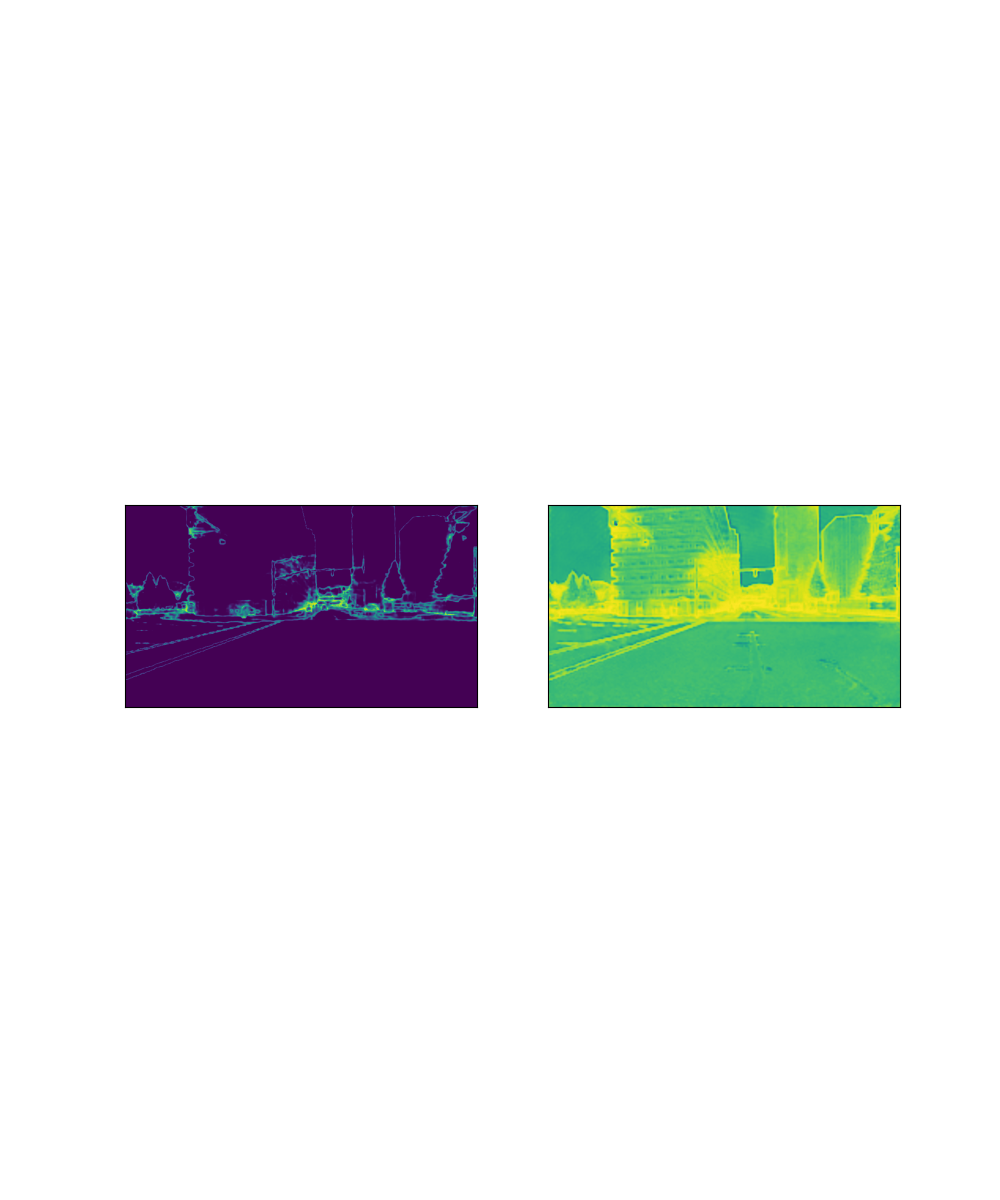

In [21]:
with torch.no_grad():
    for batch in test_dl:
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
                    
        logits = feature_extractor(imgs)
        probability_vector = get_probability(logits,Prototype,device)
    
        fig, axs = plt.subplots(1, 2, figsize=(10, 12))
        idx = 2
        
        visualize_scene(np.rot90(MMSP(probability_vector)[5].cpu().detach().numpy()), axs[0])
        visualize_scene(np.rot90(Probability_EDS(logits)[5].cpu().detach().numpy()), axs[1])
        
        break
    

In [22]:
def Anomaly_probability(MMSP_map, P_EDS_map, gamma, beta):

    alpha = 1 / (1 + torch.exp(-beta * (P_EDS_map - gamma)))

    Anomaly_p = alpha * P_EDS_map + (1 - alpha) * MMSP_map
    return Anomaly_p

def Final_map(logits, lambda_value, gamma, beta):

    probability_vector = get_probability(logits, Prototype, device) 
    vector_mmsp = MMSP(probability_vector) 
    vector_eds = Probability_EDS(logits) 
    Anomaly_map = Anomaly_probability(vector_mmsp, vector_eds, gamma, beta) # (B, H, W)
    segmentation_map = torch.argmax(probability_vector, dim=3) # (B, H, W)
    ood_label = 13 
    final_map = torch.where(Anomaly_map <= lambda_value, segmentation_map, torch.full_like(segmentation_map, ood_label))

    return final_map.cpu().numpy(), Anomaly_map.cpu().numpy()
    

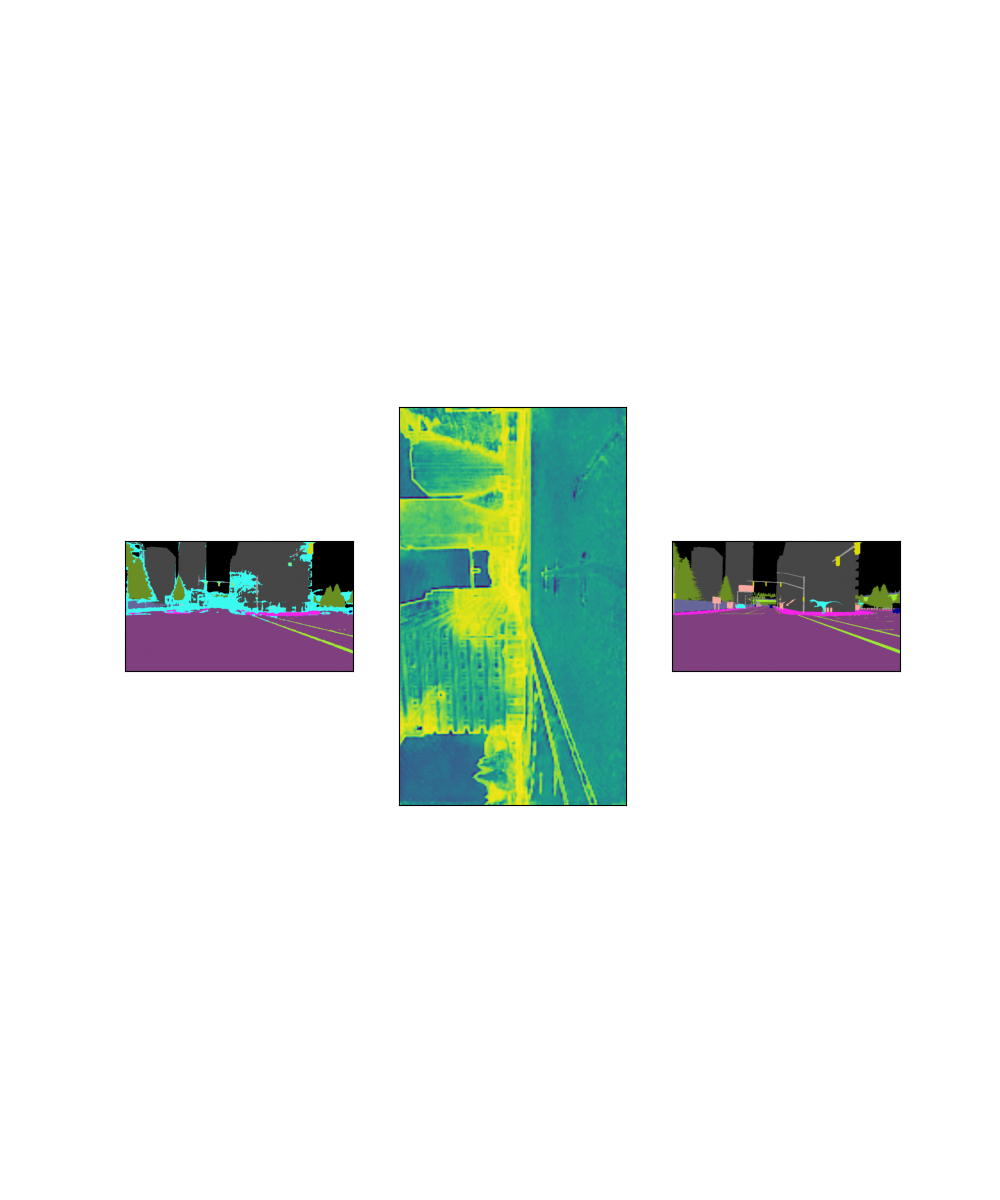

In [23]:
lambda_value = 0.7
with torch.no_grad():
    for batch in test_dl:
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
    
        fig, axs = plt.subplots(1, 3, figsize=(10, 12))
        idx = 2

        visualize_annotation(Final_map(logits,lambda_value,0.5,20)[0][5], axs[0])
        visualize_scene(Final_map(logits,lambda_value,0.5,20)[1][5], axs[1])
        visualize_annotation(labels.cpu().detach().numpy()[5],axs[2])
        
        break

In [24]:
def process_annotations_for_training(annotations_dict: dict):
    """
    Questa funzione prende le annotazioni e avvia il passo successivo,
    come preparare un dataloader o avviare il training incrementale.
    """
    print("\n" + "="*50)
    print("--- Inizio del processo di training con le nuove annotazioni ---")
    
    if not annotations_dict:
        print("Nessuna annotazione fornita. Salto il training.")
        return

    for class_name, mask_array in annotations_dict.items():
        print(f"Processo la classe: '{class_name}'")
        print(f"  - La maschera ricevuta è un array NumPy di shape: {mask_array.shape}")
        print(f"  - Tipo di dati della maschera: {mask_array.dtype}")
        print(f"  - Numero di pixel etichettati: {np.sum(mask_array)}")
        
        #
        # QUI è dove passeresti la `mask_array` al tuo dataloader 
        # o alla tua funzione `model.incremental_learn_step(...)`
        #
        print("  - Maschera pronta per essere usata nel training incrementale.")
        print("-" * 20)
    
    print("="*50)

In [25]:
#labeler_session = KaggleInteractiveLabeler(
#    image_array=dummy_image_array,
#    anomaly_map=dummy_anomaly_map,
#    threshold=0.8,
#    on_done_callback=process_annotations_for_training # Passa la funzione come callback
#)

# Mostra l'interfaccia utente
#display(labeler_session.ui)

In [26]:
class DMLNetHead(nn.Module):
    def __init__(self, feature_dim, num_classes):
        """
        Una head di classificazione per la DMLNet.
        
        Args:
            feature_dim (int): La dimensione dei canali delle feature in input (es. 256).
            num_classes (int): Il numero di classi che questa head deve gestire.
        """
        super().__init__()
        self.feature_dim = feature_dim
        self.num_classes = num_classes

        # I prototipi sono il "cuore" della head. Usiamo nn.Embedding che è
        # essenzialmente una tabella di lookup, perfetta per i prototipi.
        # Ogni classe ha un prototipo di dimensione `feature_dim`.
        self.prototypes = nn.Embedding(num_classes, feature_dim)
        
        # Inizializzazione (opzionale ma consigliata)
        nn.init.kaiming_normal_(self.prototypes.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, features):
        """
        Calcola i logit (distanze negative) per ogni pixel.
        
        Args:
            features (torch.Tensor): Mappa di feature dal backbone (B, C, H, W).
            
        Returns:
            torch.Tensor: Mappa di logit (B, num_classes, H, W).
        """
        B, C, H, W = features.shape
        
        # Riformatta le feature per il calcolo delle distanze
        # (B, C, H, W) -> (B*H*W, C)
        features_flat = features.permute(0, 2, 3, 1).contiguous().view(-1, C)
        
        # Prendi tutti i prototipi (num_classes, C)
        prototypes_all = self.prototypes.weight
        
        # Calcola le distanze Euclidee al quadrato
        # ||a-b||^2 = a^2 - 2ab + b^2
        # Questo è più efficiente di un loop
        dist_sq = (torch.sum(features_flat**2, dim=1, keepdim=True) +
                   torch.sum(prototypes_all**2, dim=1) -
                   2 * torch.matmul(features_flat, prototypes_all.t()))
        
        # Vogliamo che i logit siano alti per distanze piccole, quindi usiamo la distanza negativa.
        # (B*H*W, num_classes)
        logits_flat = -dist_sq
        
        # Riformatta i logit alla dimensione originale dell'immagine
        # (B*H*W, num_classes) -> (B, H, W, num_classes) -> (B, num_classes, H, W)
        logits = logits_flat.view(B, H, W, self.num_classes).permute(0, 3, 1, 2)
        
        return logits

In [27]:
class DMLNetWithPLM(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor
        
        # Usiamo un ModuleList per registrare correttamente le head
        # Conterrà la sequenza di head addestrate: hin, hin+1, hin+2, ...
        # L'ultima head nella lista è sempre quella più aggiornata e completa.
        self.trained_heads = nn.ModuleList()

    def get_current_head(self):
        """Restituisce l'head più recente e potente."""
        if not self.trained_heads:
            raise ValueError("Nessuna head è stata ancora aggiunta/addestrata.")
        return self.trained_heads[-1]

    def forward(self, x):
        """
        Metodo di inferenza. Usa solo il feature_extractor e l'head più recente.
        """
        features = self.feature_extractor(x)
        logits = self.get_current_head()(features)
        # Per ottenere la mappa di segmentazione finale:
        # return torch.argmax(logits, dim=1)
        return logits

    def add_initial_head(self, num_initial_classes):
        """
        Aggiunge e registra la prima head dopo il training iniziale.
        Questa head viene addestrata separatamente sulle N classi base.
        """
        feature_dim = self.feature_extractor.feature_projection.out_channels
        initial_head = DMLNetHead(feature_dim, num_initial_classes)
        self.trained_heads.append(initial_head)
        print(f"Aggiunta head iniziale per {num_initial_classes} classi.")

    @torch.no_grad()
    def generate_pseudo_label_map(self, image, novel_class_annotation, novel_class_id):
        """
        Genera la mappa di pseudo-label come descritto nell'Algoritmo 1.
        
        Args:
            image: L'immagine di input per il training.
            novel_class_annotation: La maschera binaria (0/1) per la nuova classe (Y_out,k+1).
            novel_class_id: L'ID numerico da assegnare alla nuova classe (es. N+k+1).
        """
        self.eval() # Assicurati di essere in modalità valutazione

        features = self.feature_extractor(image)
        
        # --- Algoritmo 1, Step 1-6: Genera Min,k ---
        # Parte con le predizioni della head iniziale (Min)
        initial_head = self.trained_heads[0]
        logits_initial = initial_head(features)
        pseudo_label_map = torch.argmax(logits_initial, dim=1)
        
        # Itera sulle head intermedie (quelle per le OOD class già imparate)
        # per raffinare la mappa di pseudo-label.
        # Nota: il paper è un po' ambiguo qui. Un'interpretazione è che ogni
        # `hout,t` è una head binaria. Un'interpretazione più robusta (che seguiamo)
        # è che `trained_heads[t]` è una head completa per `N+t` classi.
        
        # Per semplicità, la logica più diretta è usare le predizioni dell'ultima
        # head conosciuta (`self.trained_heads[-1]`) come base per le classi vecchie.
        if len(self.trained_heads) > 1:
            last_known_head = self.get_current_head()
            logits_known = last_known_head(features)
            pseudo_label_map = torch.argmax(logits_known, dim=1)

        # --- Algoritmo 1, Step 8: Applica l'annotazione della nuova classe ---
        # Sovrascrivi la mappa con le annotazioni della nuova classe dove presenti.
        # PLin+k[Yout,k+1 = 1] ← N + k + 1
        mask_novel = (novel_class_annotation == 1)
        pseudo_label_map[mask_novel] = novel_class_id
        
        return pseudo_label_map

    def incremental_learn_step(self, dataloader_novel_class, optimizer_class, learning_rate):
        """
        Esegue un passo completo di learning incrementale per una nuova classe.
        """
        # 1. Congela tutto il modello esistente
        self.feature_extractor.eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        for head in self.trained_heads:
            head.eval()
            for param in head.parameters():
                param.requires_grad = False

        # 2. Definisci la nuova head
        feature_dim = self.feature_extractor.feature_projection.out_channels
        last_head = self.get_current_head()
        num_old_classes = last_head.num_classes
        num_new_classes = num_old_classes + 1
        
        new_head = DMLNetHead(feature_dim, num_new_classes)
        new_head.to(image.device) # Sposta la nuova head sullo stesso device
        
        # 3. Inizializzazione dei prototipi (passaggio cruciale!)
        # Copia i pesi dei prototipi dalla vecchia head alla nuova.
        with torch.no_grad():
            new_head.prototypes.weight[:num_old_classes] = last_head.prototypes.weight.clone()
        print(f"Creata nuova head per {num_new_classes} classi. Prototipi inizializzati.")

        # 4. Addestra SOLO la nuova head
        new_head.train()
        optimizer = optimizer_class(new_head.parameters(), lr=learning_rate)
        
        # Qui dovresti implementare le tue loss custom (LDCE, LVL)
        criterion = nn.CrossEntropyLoss(ignore_index=255) # Usiamo CE come placeholder

        for epoch in range(NUM_EPOCHS_INCREMENTAL): # es. 10 epoche
            for image, novel_annotation in dataloader_novel_class:
                optimizer.zero_grad()

                # Genera le pseudo-label al volo usando il modello congelato
                pseudo_labels = self.generate_pseudo_label_map(image, novel_annotation, novel_class_id=num_old_classes)
                
                # Forward pass sulla NUOVA head (con backbone congelato)
                with torch.no_grad():
                    features = self.feature_extractor(image)
                logits_new = new_head(features)
                
                # Calcola la loss e aggiorna i pesi della NUOVA head
                loss = criterion(logits_new, pseudo_labels.long())
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

        # 5. Aggiungi la nuova head addestrata alla lista
        new_head.eval()
        self.trained_heads.append(new_head)
        print(f"Learning incrementale completato. Il modello ora gestisce {num_new_classes} classi.")